# Weather Correlation
**Can power usage be correlated with the weather at the time?**

### Install Prerequisites
Then load modules needed

In [1]:
! pip install pandas matplotlib seaborn
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

    100% |████████████████████████████████| 215kB 6.7MB/s ta 0:00:01


### Load data
If missing, these data files are created by other notebooks

In [2]:
nrg = pd.read_pickle('data/normalized.pickle')
wx = pd.read_pickle('data/weather.pickle')

In [3]:
# Only using a few columns of weather here
wx = wx[['rel_humidity', 'air_temp', 'altimeter', 'dew_pt', 'wind_direction']]
df = pd.merge(nrg, wx, how='outer', left_index=True, right_index=True)

### Interpolate to match sampling rates
Weather is naively interpolated linearly, as weather systems are slow to change relative to the power data

In [4]:
# Interpolate weather
df.rel_humidity.interpolate(inplace=True)
df.air_temp.interpolate(inplace=True)
df.altimeter.interpolate(inplace=True)
df.dew_pt.interpolate(inplace=True)

In [5]:
# Avoid having to deal with wind crossing north (360->0)
# Propigate last value forward
df.wind_direction.fillna(method='ffill',inplace=True) 

In [6]:
# Delete pre-energy rows
df = df[~df.active.isnull()]

df.head()

,active,reactive,volts,amps,sub1,sub2,sub3,house,rel_humidity,air_temp,altimeter,dew_pt,wind_direction
dtime,,,,,,,,,,,,,
2006-12-16 17:24:00+00:00,0.678250,0.172870,0.376090,0.901961,0.0,0.033148,0.015773,0.761221,87.09,7.0,76.8858,5.0,330.0
2006-12-16 17:25:00+00:00,0.728261,0.178982,0.336995,0.920000,0.0,0.033148,0.015773,0.839338,87.09,7.0,76.8858,5.0,330.0
2006-12-16 17:26:00+00:00,0.728777,0.199359,0.326010,0.920000,0.0,0.064470,0.027562,0.836294,87.09,7.0,76.8858,5.0,330.0
2006-12-16 17:27:00+00:00,0.729291,0.200639,0.340549,0.920000,0.0,0.033148,0.015773,0.841066,87.09,7.0,76.8858,5.0,330.0
2006-12-16 17:28:00+00:00,0.647017,0.208861,0.403231,0.887640,0.0,0.033148,0.015773,0.717243,87.09,7.0,76.8858,5.0,330.0


In [7]:
# Let's work on hourly scales
df = df.resample('H').mean()
df.head()

,active,reactive,volts,amps,sub1,sub2,sub3,house,rel_humidity,air_temp,altimeter,dew_pt,wind_direction
dtime,,,,,,,,,,,,,
2006-12-16 17:00:00+00:00,0.668862,0.093746,0.369754,0.894930,0.0,0.017292,0.007882,0.755545,84.717639,7.000000,76.916492,4.597222,330.0
2006-12-16 18:00:00+00:00,0.630856,0.037468,0.367695,0.877423,0.0,0.142775,0.092067,0.673926,82.599250,6.758333,76.980415,4.000000,330.0
2006-12-16 19:00:00+00:00,0.629428,0.040033,0.324152,0.878684,0.0,0.045671,0.020914,0.691493,88.438333,5.016667,77.038200,3.258333,330.0
2006-12-16 20:00:00+00:00,0.619174,0.035580,0.351260,0.873659,0.0,0.000000,0.000000,0.687035,93.152917,3.258333,77.094715,2.258333,295.0
2006-12-16 21:00:00+00:00,0.598349,0.036159,0.451007,0.863603,0.0,0.013599,0.006107,0.660915,93.095500,2.258333,77.114400,1.258333,275.0


### Plotting
Scatter features to look for correlations

In [19]:
cols = {
    'wx': ['rel_humidity','wind_direction','altimeter','air_temp','dew_pt'],
    'pwr': ['volts', 'amps'] # ['active', 'volts', 'amps', 'house', 'sub1', 'sub2', 'sub3']
}

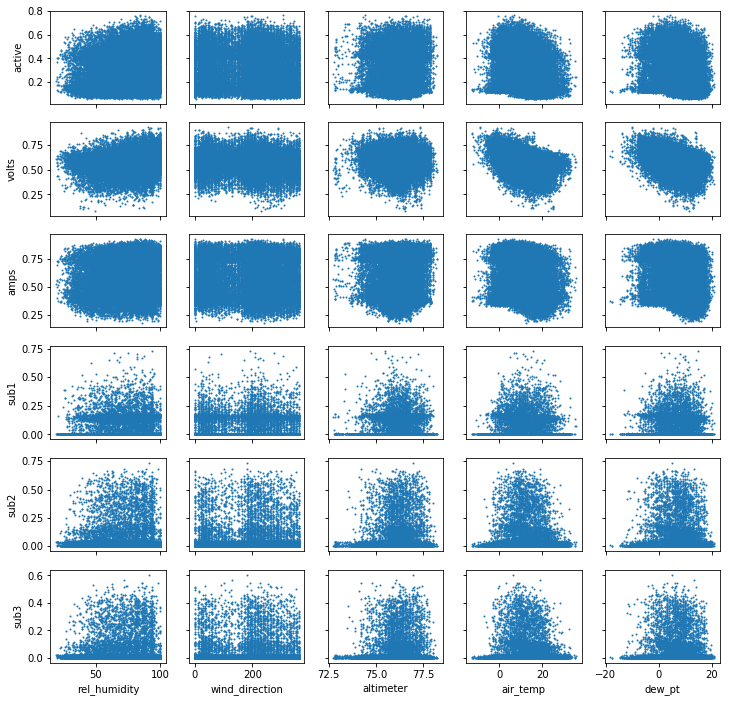

In [11]:
f, axes = plt.subplots( 
    nrows=len(cols['pwr']),
    ncols=len(cols['wx']),
    figsize=(12,12),
    sharex='col',
    sharey='row'
)


get_ax = lambda wx, pwr: [cols['pwr'].index(pwr), cols['wx'].index(wx)]

for pwr in cols['pwr']:
    for wx in cols['wx']:
        [ipwr, iwx] = get_ax(wx, pwr)
        df.plot.scatter(x=wx, y=pwr, ax=axes[ipwr, iwx], s=1)

Scatter plots are too saturated to pull out density info, try jointplots instead. Unfortunately seaborn doesn't play well with subplots..

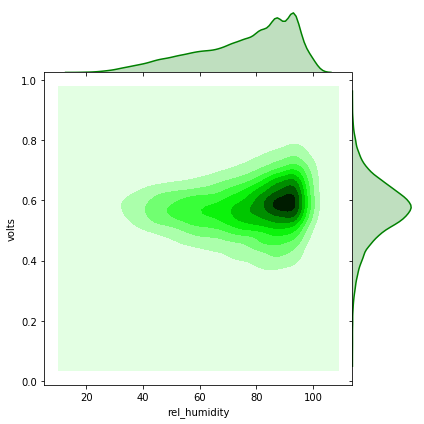

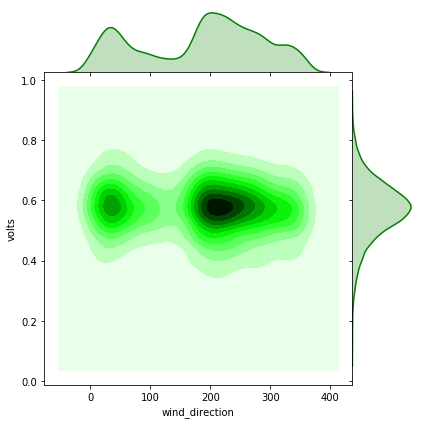

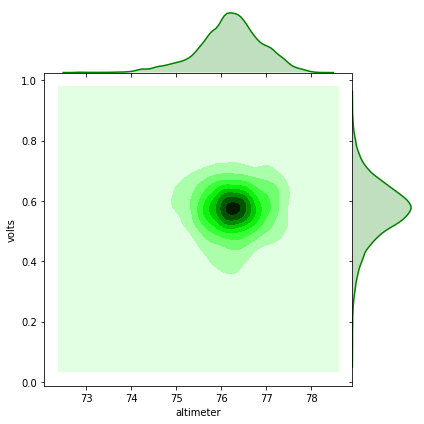

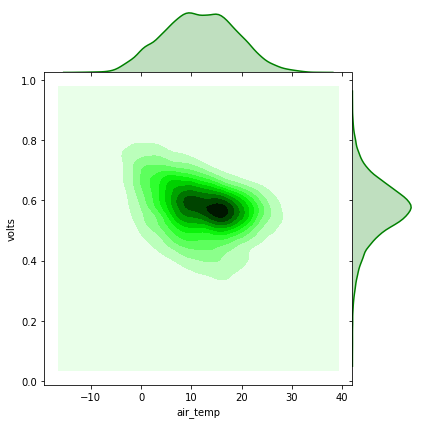

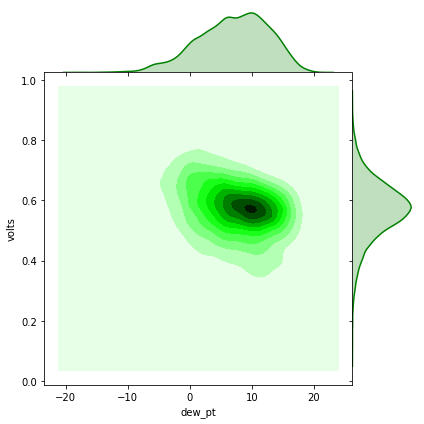

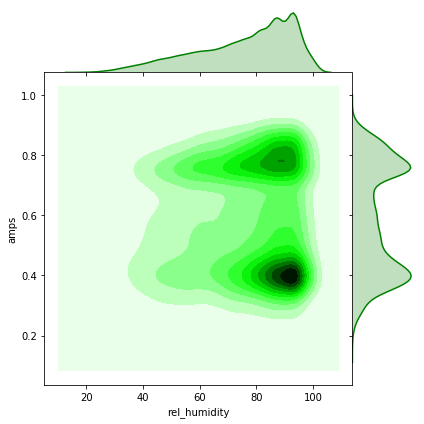

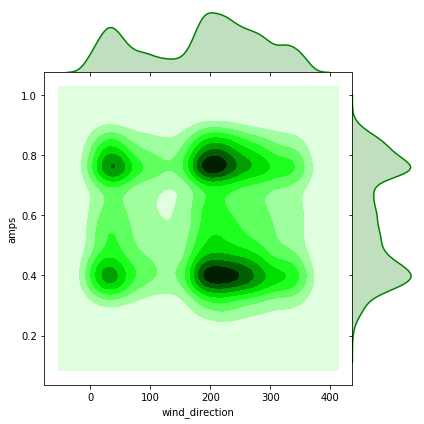

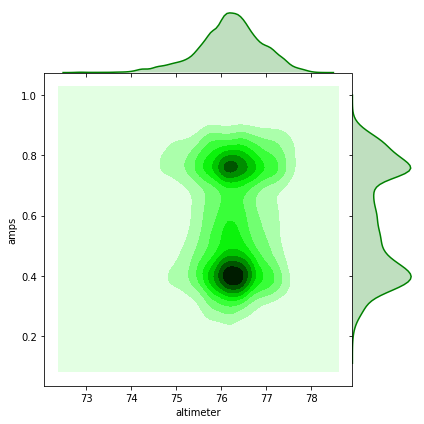

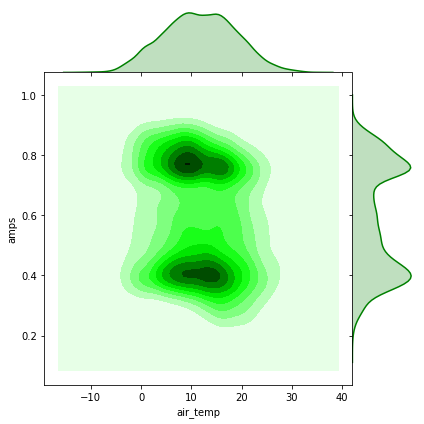

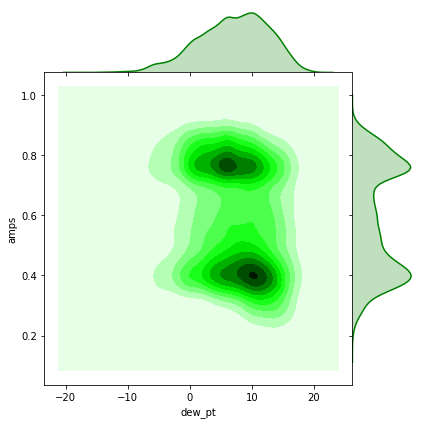

In [20]:
df_nanfree = df.dropna(how='any')

plt.rcParams.update({'figure.max_open_warning': 25})
for pwr in cols['pwr']:
    for wx in cols['wx']:
        sns.jointplot(
            data=df_nanfree,
            x=wx,
            y=pwr,
            kind="kde",
            space=0,
            color="g"
        )
plt.rcParams.update({'figure.max_open_warning': 20})